<a href="https://colab.research.google.com/github/HARSHINI20/huggingface_imgclassification/blob/main/huggingface_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install if not already in Colab
!pip install -q transformers sentencepiece torch torchvision

from google.colab import files
import zipfile
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.8 MB/s eta 0:00:00


In [4]:
from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel, pipeline
from PIL import Image
from torchvision import transforms
from google.colab import files
from sklearn.metrics.pairwise import cosine_similarity
import torch
import zipfile
import os
from IPython.display import display
import numpy as np
from sentence_transformers import SentenceTransformer, util

In [ ]:
# ✅ Step 1: Upload ZIP file (with class folders inside a parent folder like 'archive/')
print("📁 Upload your ZIP file (e.g., archive.zip) with 12 class folders...")
uploaded = files.upload()

zip_filename = next(iter(uploaded))
extract_dir = "extracted_images"
os.makedirs(extract_dir, exist_ok=True)


📁 Upload your ZIP file (e.g., archive.zip) with 12 class folders...


Saving archive.zip to archive.zip


In [ ]:
# ✅ Step 2: Extract ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"\n✅ Extracted to: {extract_dir}")


✅ Extracted to: extracted_images


In [ ]:

# ✅ Step 3: Setup image extensions and gather files recursively
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
image_files = []

for root, _, files_in_dir in os.walk(extract_dir):
    for file in files_in_dir:
        if file.lower().endswith(image_extensions):
            image_files.append(os.path.join(root, file))


In [ ]:
# ✅ Step 4: Report
if image_files:
    print(f"\n✅ Found {len(image_files)} image files in class folders.")
    print("📂 Sample images:")
    for img_path in image_files[:5]:
        print(" -", img_path)
else:
    print("⚠️ No image files found. Please check your ZIP structure.")


✅ Found 15515 image files in class folders.
📂 Sample images:
 - extracted_images/garbage_classification/plastic/plastic398.jpg
 - extracted_images/garbage_classification/plastic/plastic487.jpg
 - extracted_images/garbage_classification/plastic/plastic566.jpg
 - extracted_images/garbage_classification/plastic/plastic200.jpg
 - extracted_images/garbage_classification/plastic/plastic773.jpg


In [5]:
# === Step 2: Load Models ===
# BLIP for image captioning
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [6]:

# CLIP for text-image similarity
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [7]:
# Translator
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-mul-en")

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/310M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/310M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/707k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/791k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


In [8]:
# Sentence Transformer for caption-tweet similarity
text_embedder = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
# === Step 3: Augmentation ===
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [16]:
# === Step 4: Helper Functions ===
def get_blip_caption(image_tensor):
    image_pil = transforms.ToPILImage()(image_tensor).convert("RGB")
    inputs = blip_processor(images=image_pil, return_tensors="pt")
    out = blip_model.generate(**inputs)
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption

In [17]:
def get_clip_similarity(image_tensor, text):
    image_pil = transforms.ToPILImage()(image_tensor).convert("RGB")
    inputs = clip_processor(text=[text], images=image_pil, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    return probs[0][0].item()


In [18]:
# Get multilingual tweet
tweet = input("✏️ Enter the tweet in any language: ")
translated = translator(tweet, max_length=100)[0]['translation_text']

✏️ Enter the tweet in any language: clear the trash from my street


In [35]:
# === Step 5: Upload Test Image + Tweet ===
print("\n\n📥 Upload image to test against a tweet:")
uploaded_img = files.upload()
img_path = list(uploaded_img.keys())[0]
image = Image.open(img_path).convert("RGB")
image_tensor = augmentation(image)



📥 Upload image to test against a tweet:


Saving sample4.jpeg to sample4.jpeg


In [36]:

# BLIP caption
caption = get_blip_caption(image_tensor)

In [37]:
print(f"📷 BLIP Caption: {caption}")

📷 BLIP Caption: a picture of a group of plastic bottles


In [38]:
# CLIP text-image similarity
clip_score = get_clip_similarity(image_tensor, translated)


In [39]:

# Text similarity between caption and tweet
caption_emb = text_embedder.encode(caption, convert_to_tensor=True)
tweet_emb = text_embedder.encode(translated, convert_to_tensor=True)
text_sim_score = util.cos_sim(caption_emb, tweet_emb).item()

In [40]:
# Final Match Decision
final_match = "✅ MATCH" if clip_score > 0.3 and text_sim_score > 0.5 else "❌ NOT A MATCH"



=== 🔍 Analysis Result ===
📷 BLIP Caption: a picture of a group of plastic bottles
📝 Translated Tweet: clear the trash from my street
🎯 CLIP Image–Tweet Similarity: 1.00
🔤 Caption–Tweet Text Similarity: 0.07
🔎 Final Match Decision: ❌ NOT A MATCH


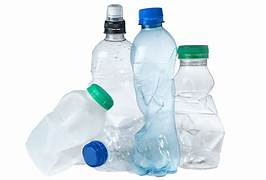

In [41]:
# === Step 6: Output ===
print("\n\n=== 🔍 Analysis Result ===")
print(f"📷 BLIP Caption: {caption}")
print(f"📝 Translated Tweet: {translated}")
print(f"🎯 CLIP Image–Tweet Similarity: {clip_score:.2f}")
print(f"🔤 Caption–Tweet Text Similarity: {text_sim_score:.2f}")
print(f"🔎 Final Match Decision: {final_match}")
display(image)


In [1]:
# Step 1: Upload test image and multilingual tweet
# 📥 Input: Image (e.g., garbage photo) and Tweet (any language)

# Step 2: Translate tweet to English
# Model: Helsinki-NLP/opus-mt-mul-en
# 🔁 Translation Model
# Purpose: Convert multilingual tweet → English for further comparison

# Step 3: Generate image caption
# Model: Salesforce/blip-image-captioning-base
# 🧠 BLIP Image Captioning
# Purpose: Understand image content and convert to text (caption)

# Step 4: Compute image–tweet similarity
# Model: openai/clip-vit-base-patch32
# 📷 CLIP (Vision-Text Alignment)
# Input: Translated tweet + image
# Output: Similarity score → How well the image matches the tweet

# Step 5: Compute caption–tweet similarity
# Model: sentence-transformers/all-MiniLM-L6-v2
# 🔤 Textual Semantic Similarity
# Input: Translated tweet + BLIP caption
# Output: Cosine similarity → Measures semantic match

# Step 6: Final Decision
# ✅ MATCH if:
#    - CLIP similarity > 0.3 (image vs tweet)
#    - Text similarity > 0.5 (caption vs tweet)
# ❌ NOT A MATCH otherwise

# Step 7 (Optional): Augmentation applied to test image before processing
# Module: torchvision.transforms
# 📈 Used to slightly vary the image → more robust captioning/prediction
